In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns


In [25]:
cols = ["trade_id", "price", "qty", "quote_qty", "time", "is_buyer_maker", "is_best_match"]

df = pd.read_csv('BTCUSDT-trades-2025-11-09.csv', header = None, names = cols)
df.head()

,trade_id,price,qty,quote_qty,time,is_buyer_maker,is_best_match
0,5457384177,102312.95,0.00014,14.323813,1762646400161217,False,True
1,5457384178,102312.95,0.00009,9.208165,1762646400230658,False,True
2,5457384179,102312.95,0.00029,29.670755,1762646400339172,False,True
3,5457384180,102312.95,0.00390,399.020505,1762646400425865,False,True
4,5457384181,102312.95,0.00048,49.110216,1762646400461588,False,True


In [26]:
time_unit = "ms" if df["time"].iloc[0] < 1e14 else "us"
df["ts"] = pd.to_datetime(df["time"], unit=time_unit, utc=True)

#df["time_only"] = df["ts"].dt.time

In [27]:
df["is_buyer_maker"] = df["is_buyer_maker"].astype("int64")
df['is_best_match'] = df['is_best_match'].astype('int64')
#df.index = df['time_only']
df.index = df['ts']
df = df.drop('ts', axis = 1)
df = df.drop(['trade_id','time'], axis = 1)
df

,price,qty,quote_qty,is_buyer_maker,is_best_match
ts,,,,,
2025-11-09 00:00:00.161217+00:00,102312.95,0.00014,14.323813,0,1
2025-11-09 00:00:00.230658+00:00,102312.95,0.00009,9.208165,0,1
2025-11-09 00:00:00.339172+00:00,102312.95,0.00029,29.670755,0,1
2025-11-09 00:00:00.425865+00:00,102312.95,0.00390,399.020505,0,1
2025-11-09 00:00:00.461588+00:00,102312.95,0.00048,49.110216,0,1
...,...,...,...,...,...
2025-11-09 23:59:58.663692+00:00,104722.95,0.00005,5.236148,1,1
2025-11-09 23:59:58.663692+00:00,104722.95,0.00005,5.236148,1,1
2025-11-09 23:59:58.663692+00:00,104722.95,0.00005,5.236148,1,1


In [28]:
m = df['is_buyer_maker'].astype(bool)
df['buy_qty'] = df['qty'].where(~m, 0.0) 
df['sell_qty'] = df['qty'].where(m, 0.0)

g = df.resample('1min')

bars = pd.DataFrame({
    "open":      g["price"].first(),
    "high":      g["price"].max(),
    "low":       g["price"].min(),
    "close":     g["price"].last(),
    "vol_qty":   g["qty"].sum(),
    "vol_quote": g["quote_qty"].sum(),
    "n_trades":  g["price"].size(),
    "buy_qty":   g["buy_qty"].sum(),
    "sell_qty":  g["sell_qty"].sum(),
})

bars

,open,high,low,close,vol_qty,vol_quote,n_trades,buy_qty,sell_qty
ts,,,,,,,,,
2025-11-09 00:00:00+00:00,102312.95,102323.33,102293.03,102293.04,4.61997,4.726821e+05,1602,1.17689,3.44308
2025-11-09 00:01:00+00:00,102293.03,102300.31,102276.08,102280.44,6.96124,7.120312e+05,2165,1.33179,5.62945
2025-11-09 00:02:00+00:00,102280.44,102313.89,102280.43,102313.88,1.18451,1.211743e+05,818,0.89168,0.29283
2025-11-09 00:03:00+00:00,102313.88,102329.96,102293.51,102329.95,9.29856,9.513247e+05,3261,5.23692,4.06164
2025-11-09 00:04:00+00:00,102329.95,102337.89,102324.77,102334.49,2.65148,2.713205e+05,1176,1.70625,0.94523
...,...,...,...,...,...,...,...,...,...
2025-11-09 23:55:00+00:00,104752.64,104762.30,104732.95,104754.54,19.32669,2.024454e+06,1568,12.52556,6.80113
2025-11-09 23:56:00+00:00,104754.54,104754.54,104701.14,104701.14,16.92234,1.772458e+06,3019,0.88543,16.03691
2025-11-09 23:57:00+00:00,104701.14,104748.31,104701.14,104728.16,3.12427,3.271864e+05,2137,1.61872,1.50555


(-6.515652180961774, 1.0730186206896607e-08, 10, 1429, {'1%': -3.4349343845870006, '5%': -2.8635646903561653, '10%': -2.5678479326174157}, 44262.09295811807)


<Axes: xlabel='ts'>

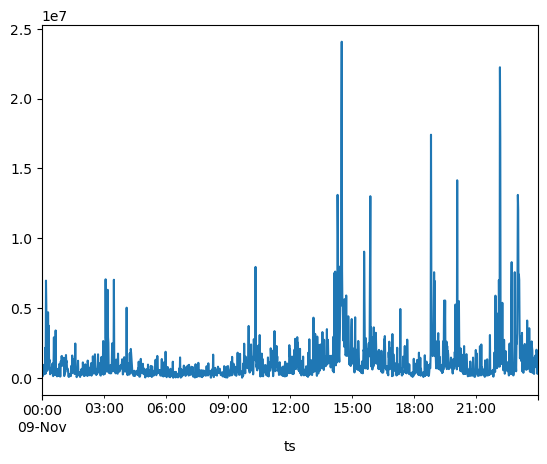

In [29]:
print(adfuller(bars['vol_quote']))
bars['vol_quote'].plot()

# Adding features: maybe make scatter plots

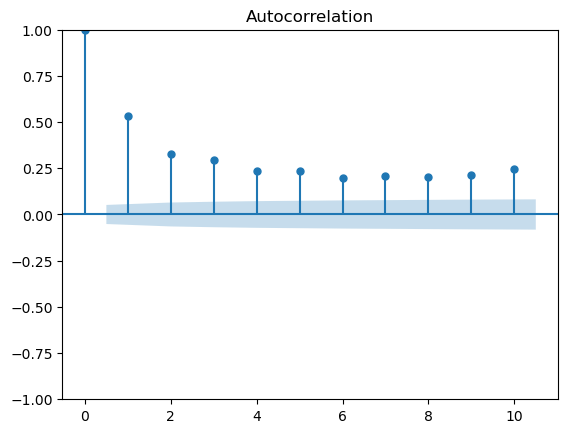

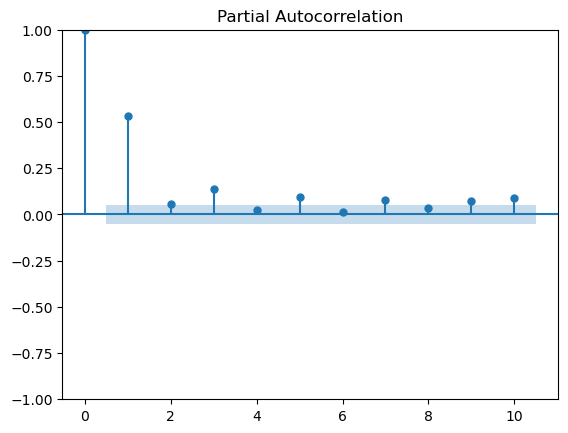

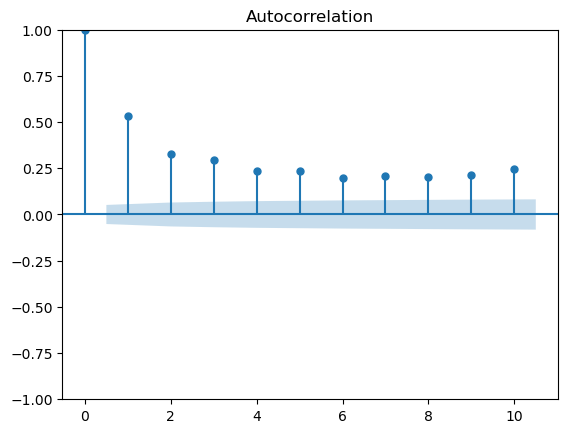

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
y = bars['vol_qty']
plot_pacf(y,lags=10)
plot_acf(y,lags=10)

In [31]:
X = bars
X

,open,high,low,close,vol_qty,vol_quote,n_trades,buy_qty,sell_qty
ts,,,,,,,,,
2025-11-09 00:00:00+00:00,102312.95,102323.33,102293.03,102293.04,4.61997,4.726821e+05,1602,1.17689,3.44308
2025-11-09 00:01:00+00:00,102293.03,102300.31,102276.08,102280.44,6.96124,7.120312e+05,2165,1.33179,5.62945
2025-11-09 00:02:00+00:00,102280.44,102313.89,102280.43,102313.88,1.18451,1.211743e+05,818,0.89168,0.29283
2025-11-09 00:03:00+00:00,102313.88,102329.96,102293.51,102329.95,9.29856,9.513247e+05,3261,5.23692,4.06164
2025-11-09 00:04:00+00:00,102329.95,102337.89,102324.77,102334.49,2.65148,2.713205e+05,1176,1.70625,0.94523
...,...,...,...,...,...,...,...,...,...
2025-11-09 23:55:00+00:00,104752.64,104762.30,104732.95,104754.54,19.32669,2.024454e+06,1568,12.52556,6.80113
2025-11-09 23:56:00+00:00,104754.54,104754.54,104701.14,104701.14,16.92234,1.772458e+06,3019,0.88543,16.03691
2025-11-09 23:57:00+00:00,104701.14,104748.31,104701.14,104728.16,3.12427,3.271864e+05,2137,1.61872,1.50555


In [32]:
X.columns

Index(['open', 'high', 'low', 'close', 'vol_qty', 'vol_quote', 'n_trades',
       'buy_qty', 'sell_qty'],
      dtype='object')

In [33]:
# Time features

X['HOD'] = X.index.hour
X['MOH'] = X.index.minute
X['is_last_5_min'] = (X['MOH'] >= 55).astype('int8')
X['is_first_5_min'] = (X['MOH'] <= 5).astype('int8')
X['is_quarter_end'] = X['MOH'].isin([14,29,44,59]).astype('int8')

In [34]:
# Price features and lags

X['ylag1'] = X['vol_qty'].shift(1)
X['ylag2'] = X['vol_qty'].shift(2)
X['ylag3'] = X['vol_qty'].shift(3)
X['ylag4'] = X['vol_qty'].shift(4)
X['ylag5'] = X['vol_qty'].shift(5)

X['returns'] = X['open'].pct_change()
X['previous_close'] = X['close'].shift(1)
X['previous_open'] = X['open'].shift(1)
X['gap_pct_close_open'] = (X['open'] - X['previous_close']) / X['previous_close']

X['range'] = (X['previous_open'] - X['previous_close']) / X['previous_close']
X['ma5'] = X['open'].rolling(10).mean()
X['ma60'] = X['open'].rolling(60).mean()
X['std5'] = X['open'].rolling(10).std()
X['std60'] = X['open'].rolling(60).std()

X['direction_ma_based'] = (X['ma5'] - X['ma60'])/ X['std60']

X['qty_last60s'] = X['ylag1'].rolling(60).sum()
X['n_last60'] = X['n_trades'].rolling(60).sum()
X['imb_last30s'] = X['buy_qty'].rolling(60).sum() - X['sell_qty'].rolling(60).sum() 

In [35]:
X = X.dropna()
X

,open,high,low,close,vol_qty,vol_quote,n_trades,buy_qty,sell_qty,HOD,...,gap_pct_close_open,range,ma5,ma60,std5,std60,direction_ma_based,qty_last60s,n_last60,imb_last30s
ts,,,,,,,,,,,,,,,,,,,,,
2025-11-09 01:00:00+00:00,101797.74,101801.24,101764.56,101801.24,13.10124,1.333450e+06,3686,3.08315,10.01809,1,...,0.000000e+00,-0.000126,101837.563,101977.429333,66.553923,188.887101,-0.740476,616.42627,148586.0,-200.89098
2025-11-09 01:01:00+00:00,101801.23,101856.00,101801.23,101838.02,8.56980,8.726893e+05,2937,2.28577,6.28403,1,...,-9.823063e-08,-0.000034,101823.886,101969.232667,56.986075,185.601778,-0.783110,624.90754,149358.0,-200.59158
2025-11-09 01:02:00+00:00,101838.02,101850.97,101821.75,101821.76,11.36947,1.157793e+06,2546,2.01696,9.35251,1,...,0.000000e+00,-0.000361,101820.437,101961.859000,54.714649,181.777368,-0.777996,626.51610,151086.0,-208.52598
2025-11-09 01:03:00+00:00,101821.76,101867.41,101821.75,101867.41,12.85429,1.309102e+06,3936,6.61006,6.24423,1,...,0.000000e+00,0.000160,101813.877,101953.657000,49.481716,176.654900,-0.791260,636.70106,151761.0,-209.33543
2025-11-09 01:04:00+00:00,101867.41,101930.01,101867.41,101903.31,14.26241,1.453369e+06,4259,7.44397,6.81844,1,...,0.000000e+00,-0.000448,101812.277,101945.948000,47.189106,169.919555,-0.786672,640.25679,154844.0,-209.47092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-09 23:55:00+00:00,104752.64,104762.30,104732.95,104754.54,19.32669,2.024454e+06,1568,12.52556,6.80113,23,...,-9.546298e-08,-0.000385,104619.807,104804.346000,69.025628,201.520461,-0.915733,1264.14976,253710.0,19.91416
2025-11-09 23:56:00+00:00,104754.54,104754.54,104701.14,104701.14,16.92234,1.772458e+06,3019,0.88543,16.03691,23,...,0.000000e+00,-0.000018,104637.406,104804.267000,79.045999,201.539356,-0.827933,1273.91324,254635.0,4.35434
2025-11-09 23:57:00+00:00,104701.14,104748.31,104701.14,104728.16,3.12427,3.271864e+05,2137,1.61872,1.50555,23,...,0.000000e+00,0.000510,104651.473,104802.653667,76.302395,201.977830,-0.748501,1286.23066,251037.0,8.72565


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['feagture'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

print(vif[(vif['VIF'] > 50)])


              feagture           VIF
0                 open  9.007199e+15
1                 high  4.471930e+07
2                  low  4.401722e+07
3                close  2.780372e+07
4              vol_qty           inf
5            vol_quote  2.047139e+04
7              buy_qty           inf
8             sell_qty           inf
19             returns  8.779185e+05
20      previous_close  9.007199e+15
21       previous_open  3.594268e+10
22  gap_pct_close_open  1.214226e+04
23               range  8.496905e+05
24                 ma5  5.559018e+06
25                ma60  3.529200e+06
30            n_last60  5.561203e+01


c:\Users\fgili\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [37]:
X = X[['n_trades', 'HOD', 'MOH',
       'is_last_5_min', 'is_first_5_min', 'is_quarter_end', 'ylag1', 'ylag2',
       'ylag3', 'ylag4', 'ylag5', 'gap_pct_close_open', 'range', 'ma5', 'std5', 'std60', 'vol_qty', 'direction_ma_based', 'qty_last60s', 'n_last60', 'imb_last30s']]

X = X.dropna()
X


,n_trades,HOD,MOH,is_last_5_min,is_first_5_min,is_quarter_end,ylag1,ylag2,ylag3,ylag4,...,gap_pct_close_open,range,ma5,std5,std60,vol_qty,direction_ma_based,qty_last60s,n_last60,imb_last30s
ts,,,,,,,,,,,,,,,,,,,,,
2025-11-09 01:00:00+00:00,3686,1,0,0,1,0,10.55238,15.55645,15.24098,8.77652,...,0.000000e+00,-0.000126,101837.563,66.553923,188.887101,13.10124,-0.740476,616.42627,148586.0,-200.89098
2025-11-09 01:01:00+00:00,2937,1,1,0,1,0,13.10124,10.55238,15.55645,15.24098,...,-9.823063e-08,-0.000034,101823.886,56.986075,185.601778,8.56980,-0.783110,624.90754,149358.0,-200.59158
2025-11-09 01:02:00+00:00,2546,1,2,0,1,0,8.56980,13.10124,10.55238,15.55645,...,0.000000e+00,-0.000361,101820.437,54.714649,181.777368,11.36947,-0.777996,626.51610,151086.0,-208.52598
2025-11-09 01:03:00+00:00,3936,1,3,0,1,0,11.36947,8.56980,13.10124,10.55238,...,0.000000e+00,0.000160,101813.877,49.481716,176.654900,12.85429,-0.791260,636.70106,151761.0,-209.33543
2025-11-09 01:04:00+00:00,4259,1,4,0,1,0,12.85429,11.36947,8.56980,13.10124,...,0.000000e+00,-0.000448,101812.277,47.189106,169.919555,14.26241,-0.786672,640.25679,154844.0,-209.47092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-09 23:55:00+00:00,1568,23,55,1,0,0,7.36036,12.08033,15.43810,9.47610,...,-9.546298e-08,-0.000385,104619.807,69.025628,201.520461,19.32669,-0.915733,1264.14976,253710.0,19.91416
2025-11-09 23:56:00+00:00,3019,23,56,1,0,0,19.32669,7.36036,12.08033,15.43810,...,0.000000e+00,-0.000018,104637.406,79.045999,201.539356,16.92234,-0.827933,1273.91324,254635.0,4.35434
2025-11-09 23:57:00+00:00,2137,23,57,1,0,0,16.92234,19.32669,7.36036,12.08033,...,0.000000e+00,0.000510,104651.473,76.302395,201.977830,3.12427,-0.748501,1286.23066,251037.0,8.72565


In [38]:
len(X)
X.index[1000]

Timestamp('2025-11-09 17:40:00+0000', tz='UTC')

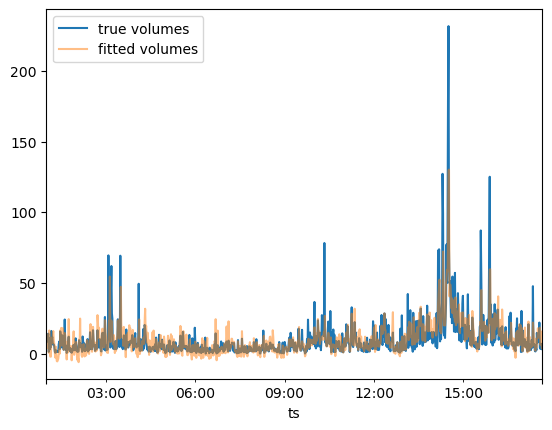

[]

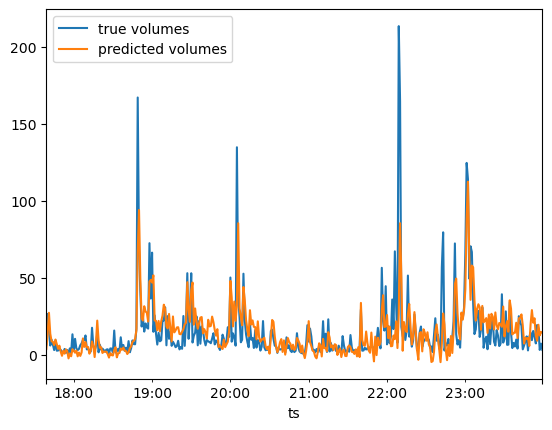

In [39]:
divider = '2025-11-09 17:39:00+0000'
y = X['vol_qty']
X = X.drop('vol_qty', axis = 1)

X_train = X.loc[:divider]
X_test = X.loc[divider:]

#print(X_train)
y_train = y.loc[:divider]
y_test = y.loc[divider:]

model = regression.linear_model.OLS(y_train,sm.add_constant(X_train)).fit()

y_fitted = model.predict(sm.add_constant(X_train))
y_predicted = model.predict(sm.add_constant(X_test))

y_train.plot(label = 'true volumes')
y_fitted.plot(label = 'fitted volumes', alpha = 0.5)
plt.legend()
plt.show()

y_test.plot(label = 'true volumes')
y_predicted.plot(label = 'predicted volumes')
plt.legend()
plt.plot()


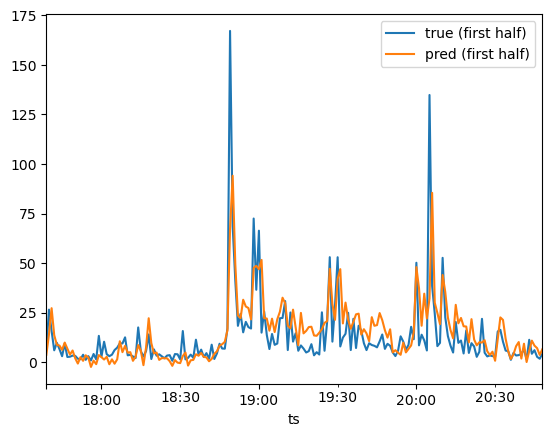

In [40]:
half = len(y_test) // 2

ax = y_test.iloc[:half].plot(label="true (first half)")
y_predicted.iloc[:half].plot(ax=ax, label="pred (first half)")
plt.legend(); plt.show()

(-8.826687669072093, 1.8155442800939175e-14, 2, 378, {'1%': -3.4477686860685, '5%': -2.869216670067509, '10%': -2.570859500573892}, 3090.467407671032)


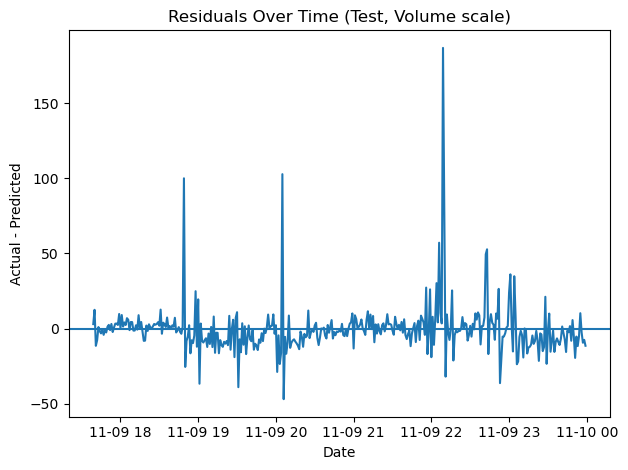

In [41]:
resid_test = y_test - y_predicted

print(adfuller(resid_test))
plt.plot(resid_test.index, resid_test.values)
plt.title('Residuals Over Time (Test, Volume scale)')
plt.axhline(0.0)
plt.xlabel('Date'); plt.ylabel('Actual - Predicted')
plt.tight_layout(); plt.show()

<Axes: xlabel='vol_qty'>

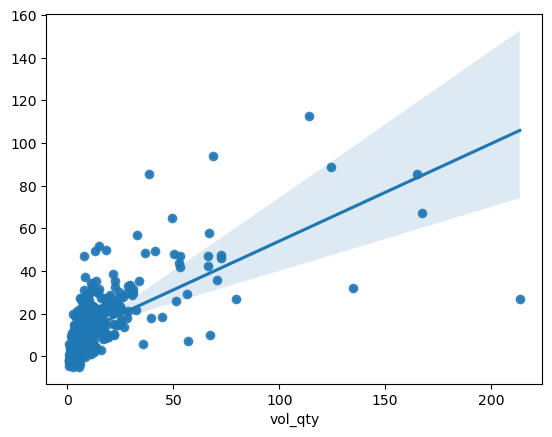

In [42]:
import seaborn as sns
plt.scatter(y_test.values, y_predicted.values, s=12, alpha=0.7)
sns.regplot(x=y_test, y=y_predicted)

In [43]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

print(het_breuschpagan(model.resid, model.model.exog)) # check homoskedasticity, small p reject
print(durbin_watson(model.resid)) # check autocorrelation < 2 pos autocorr, ~2 top, > 2 neg autocorr

(303.9606415477071, 1.2543860739494363e-52, 21.37648284264383, 1.0491299603055487e-63)
1.8959623443745726


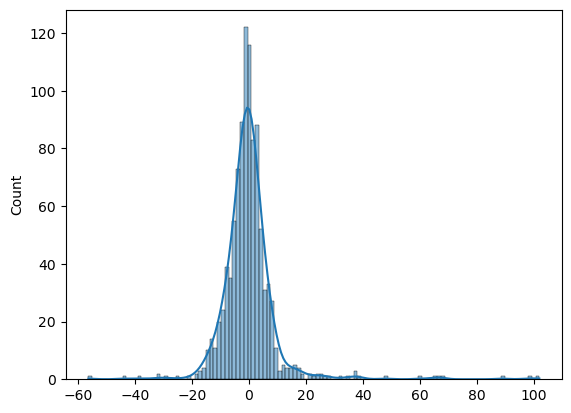

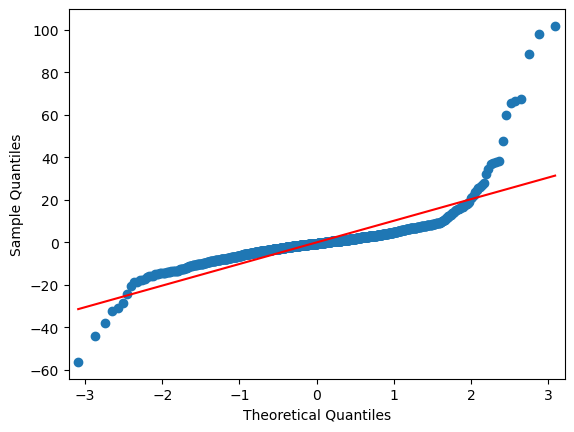

(45340.62603437144, 0.0, 3.639203216872963, 35.17452135790244)


In [44]:
sns.histplot(model.resid, kde = True)
plt.show()
sm.qqplot(model.resid, line = 's')
plt.show()

from statsmodels.stats.stattools import jarque_bera
print(jarque_bera(model.resid)) # check normality, small p I reject normality
# .fit(cov_type="HC3")

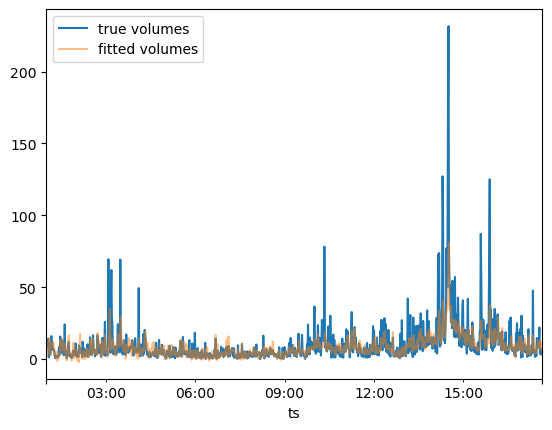

[]

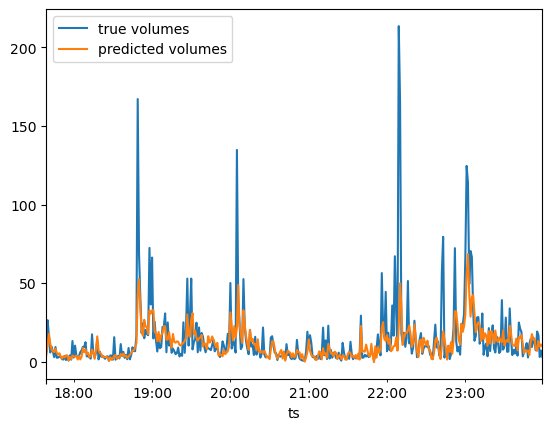

In [45]:
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT

# X_train, X_test are your feature matrices; add intercept
X_train_c = sm.add_constant(X_train)
X_test_c  = sm.add_constant(X_test, has_constant="add")

# Huber robust regression (t≈1.345 is common; tune if needed)
model = sm.RLM(y_train, X_train_c, M=HuberT(t=1.345)).fit()

y_fitted = model.predict(sm.add_constant(X_train_c))
y_predicted = model.predict(sm.add_constant(X_test_c))

y_train.plot(label = 'true volumes')
y_fitted.plot(label = 'fitted volumes', alpha = 0.5)
plt.legend()
plt.show()

y_test.plot(label = 'true volumes')
y_predicted.plot(label = 'predicted volumes')
plt.legend()
plt.plot()